# THE BATTLE OF NEIGHBORHOODS

# Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

# Data:

For this project we need the following data:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Indian resturants in each neighborhood of new york city.
3. GeoSpace data

## Questions that will be answers at the end of this project :

### 1. What are best location in New York City for Indian Cuisine?
### 2. Which areas have potential Indian Restaurant Market?
### 3. Which all areas lack Indian Restaurants?
### 4. Which is the best place to stay if you prefer Indian Cuisine?

# Methodology:

1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Indian Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [2]:
# !pip install folium
# !pip install geocoder
# !pip install bs4

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=4ca50c8b3ee20f3c0ec583d886f05fba65962115f587f363570f7dab1ef79cd9
  Stored in directory: /Users/artur.nur/Library/Caches/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [40]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'AWIJURFRIC1ZUF12TMFZGCMQP4D1RXDF5OH5RCDCCVMPINVF' # your Foursquare ID
    CLIENT_SECRET = 'VDJ5K0TBKRKPXJRM4PM33FP0JUIWOXRJ0IG2PRCNYI50VV3F' # your Foursquare Secret
    ACCESS_TOKEN = 'BUNJF3OQFCFMUOVHOUHHFBCL34L5EL2GVF1SDSC3ZKJXCAMO' # your FourSquare Access Token
    VERSION = '20210101'
 
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    try:
        venue_data=results["response"]['groups'][0]['items']
    except KeyError:
        pass
    
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [41]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'AWIJURFRIC1ZUF12TMFZGCMQP4D1RXDF5OH5RCDCCVMPINVF' # your Foursquare ID
    CLIENT_SECRET = 'VDJ5K0TBKRKPXJRM4PM33FP0JUIWOXRJ0IG2PRCNYI50VV3F' # your Foursquare Secret
    ACCESS_TOKEN = 'BUNJF3OQFCFMUOVHOUHHFBCL34L5EL2GVF1SDSC3ZKJXCAMO' # your FourSquare Access Token
    VERSION = '20210101'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [42]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [43]:
new_york_data=get_new_york_data()

In [44]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [45]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

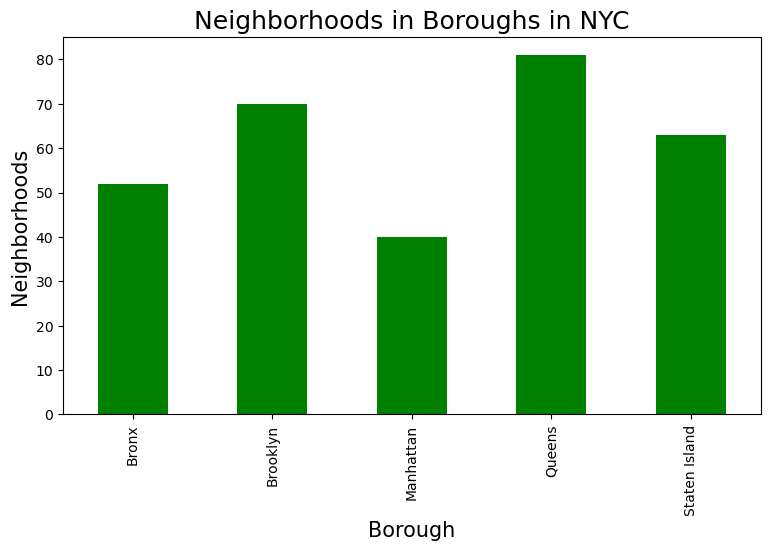

In [46]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Neighborhoods in Boroughs in NYC', fontsize = 18)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color="green")
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Indian resturants for each Neighborhood.

In [47]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    
    if count<7 or count>300:
        print('Indian Resturant No.' +str(count)+ ' from ' +str(len(new_york_data))+' in '+Neighborhood+', '+Borough)
    elif count == 150:
        print("...")
        
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

Indian Resturant No.1 from 306 in Wakefield, Bronx
Indian Resturant No.2 from 306 in Co-op City, Bronx
Indian Resturant No.3 from 306 in Eastchester, Bronx
Indian Resturant No.4 from 306 in Fieldston, Bronx
Indian Resturant No.5 from 306 in Riverdale, Bronx
Indian Resturant No.6 from 306 in Kingsbridge, Bronx
...
Indian Resturant No.301 from 306 in Erasmus, Brooklyn
Indian Resturant No.302 from 306 in Hudson Yards, Manhattan
Indian Resturant No.303 from 306 in Hammels, Queens
Indian Resturant No.304 from 306 in Bayswater, Queens
Indian Resturant No.305 from 306 in Queensbridge, Queens
Indian Resturant No.306 from 306 in Fox Hills, Staten Island


Now that we have got all the indian resturants in new york city , we will analyze it.

In [48]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [49]:
indian_rest_ny.shape

(148, 4)

### From the above result, we see that there are 151 Indian Resturants across New York City.

Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.

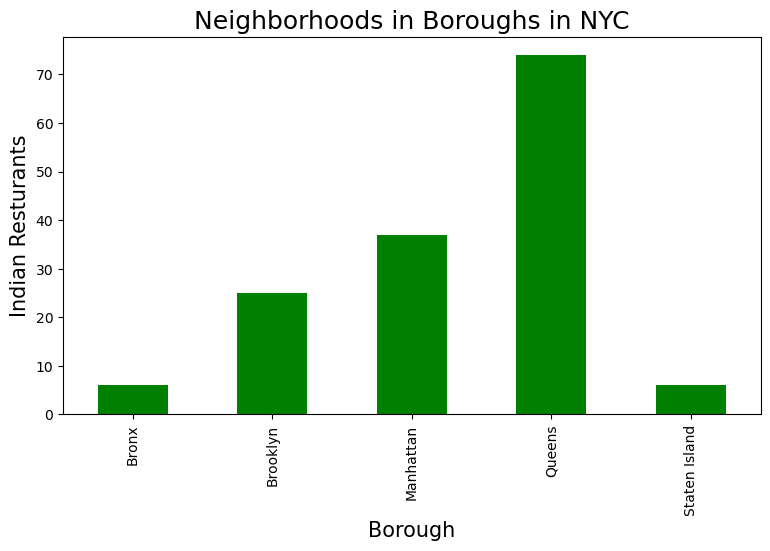

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Neighborhoods in Boroughs in NYC', fontsize = 18)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color="green")
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

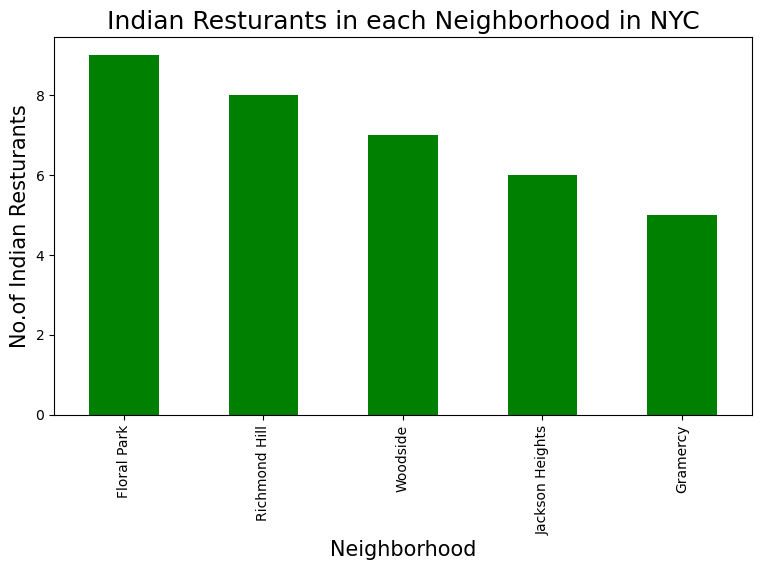

In [52]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Indian Resturants in each Neighborhood in NYC', fontsize=18)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color="green")
#displays the plot
plt.show()

In [53]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
106,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
107,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
113,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


### We can see that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 11.

Now we will get the ranking of each resturant for further analysis.

In [54]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4edfae15d3e36374e25707a0
No data available for id= 57d9e9a1498e545076560fef
No data available for id= 4ee8dddb5c5c99a2dc780825
No data available for id= 4ff35019e4b08a4c70f033b4
No data available for id= 4b96926df964a520abd534e3
No data available for id= 4cc642ed306e224b5bf2a76c
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
No data available for id= 4c66f1ac8e9120a1b266d964
No data available for id= 4dc0aaedae606fe8b71c226b
No data available for id= 4b65f2e3f964a5206e0a2be3
No data available for id= 4cb4a712db32f04dcb5adf4d
No data available for id= 4f5c0b29e4b04e12661cac80
No data available for id= 4c2e8df2213c2d7f94742f5d
No data available for id= 4b65f2e3f964a5206e0a2be3


In [55]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.4,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [56]:
indian_rest_stats_ny.shape

(148, 7)

In [57]:
indian_rest_ny.shape

(148, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [58]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [59]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [60]:
indian_rest_stats_ny_csv.shape

(148, 7)

In [61]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.4,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [62]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       148 non-null    object 
 1   Neighborhood  148 non-null    object 
 2   ID            148 non-null    object 
 3   Name          148 non-null    object 
 4   Likes         148 non-null    object 
 5   Rating        148 non-null    float64
 6   Tips          148 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.2+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [63]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [64]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       148 non-null    object 
 1   Neighborhood  148 non-null    object 
 2   ID            148 non-null    object 
 3   Name          148 non-null    object 
 4   Likes         148 non-null    float64
 5   Rating        148 non-null    float64
 6   Tips          148 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [65]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 255
Name: 38, dtype: object

In [66]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                601
Rating                               9.1
Tips                                 151
Name: 41, dtype: object

In [67]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 255
Name: 38, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [68]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [69]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
70,Tribeca,9.1
67,Sunnyside,9.1
6,Blissville,9.1
13,Civic Center,9.1
53,Prospect Heights,8.8
12,Chelsea,8.8
10,Carnegie Hill,8.8
75,West Village,8.7
44,Midtown,8.6
45,Midtown South,8.6


### Above are the top neighborhoods with top average rating of Indian resturants.

Similarly we will find the average rating of Indian Resturants for each Borough.

In [70]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [71]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.270270
1,Brooklyn,7.708000
0,Bronx,6.450000
3,Queens,6.364865
4,Staten Island,5.433333


Lets Visualize it.

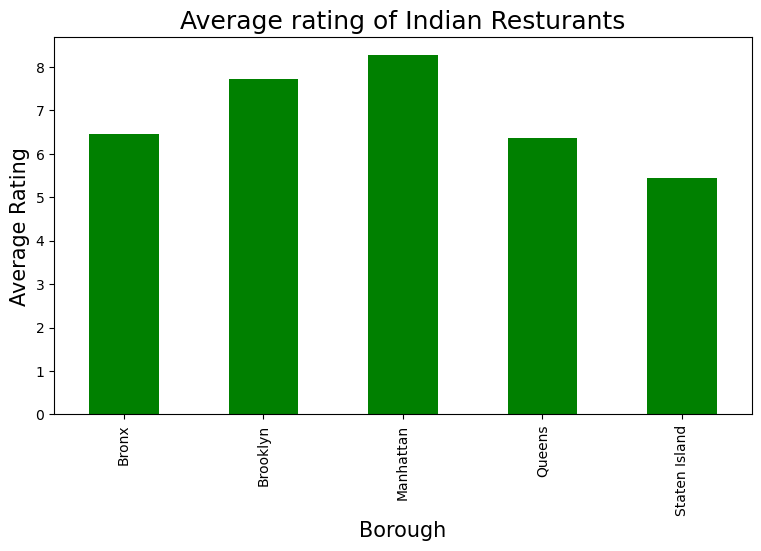

In [72]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants', fontsize=18)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="green")
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [73]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [74]:
ny_neighborhood_stats

,Neighborhood,Average Rating
6,Blissville,9.1
13,Civic Center,9.1
67,Sunnyside,9.1
70,Tribeca,9.1


We will join this dataset to original new york data to get lonitude and latitude.

In [75]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [76]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [77]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.1
1,Manhattan,Civic Center,40.715229,-74.005415,9.1
2,Queens,Sunnyside,40.740176,-73.926916,9.1
3,Staten Island,Sunnyside,40.612760,-74.097126,9.1
4,Manhattan,Tribeca,40.721522,-74.010683,9.1


Finally, Let's show this data on a map.

In [84]:
# !pip install geopy
# !pip install folium
from geopy.geocoders import Nominatim
address = 'New York City'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NYC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NYC are 40.7127281, -74.0060152.


In [85]:
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [86]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [87]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [88]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating.

In [95]:
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)
ny_geo = r'nybb.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.BoroName',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [98]:
help(folium.Map.choropleth)

Help on function choropleth in module folium.folium:

choropleth(self, *args, **kwargs)
    Call the Choropleth class with the same arguments.
    
    This method may be deleted after a year from now (Nov 2018).



# Conclusion:

### So now we can answer the questions asked above in the Questions section of the notebook.
### From our anaysis the answers to the above questions are:

#### 1) Sunnyside(Queens), Blissville(Queens), Civic Center(Manhattan), Tribeca(Manhattan) are some of the best neighborhoods for Indian cuisine.
#### 2) Manhattan have potential Indian Resturant Market.
#### 3) Staten Island ranks last in average rating of Indian Resturants.
#### 4) Manhattan is the best place to stay if you prefer Indian Cuisine.